In [2]:
import pandas as pd
import datetime
import fastf1
import numpy as np
import matplotlib.pyplot as plt
session = fastf1.get_session(2022,1,'FP1')
session.load()

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
api            INFO 	Fetching car data...
api            INFO 	Parsing car data...
api            INFO 	Fetching position data...
api            INFO 	Parsing position data...
api            INFO 	Fetching weather data...
api            INFO 	Fetching race control messages...
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '47', '44', '31', '27', '24', '23', '22'

In [3]:
#session.drivers = list with drivers that participated in the session
#what is TrackStatus?
#remember to debug the unknowntyre
#normalize time to start at the session's start
lapsDataFrame = session.laps
sessionFirstLap = lapsDataFrame["LapStartDate"].to_list()[0]
sessionOutTime = lapsDataFrame["PitOutTime"].to_list()[0]
dateTimeSST = datetime.datetime(2022,3,18,12,0,0,0)
sessionStartTime = pd.Timestamp(dateTimeSST)
helpDelta = sessionFirstLap-sessionStartTime
timeDelta = sessionOutTime-helpDelta
print(timeDelta)

0 days 00:14:59.987000


In [4]:
#add columns with corrected timestamps to dataframe
lapsDataFrame = lapsDataFrame.assign(CorrectedPitOutTime = lambda x:(x["PitOutTime"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedTime = lambda x:(x["Time"]-timeDelta))
lapsDataFrame = lapsDataFrame.assign(CorrectedPitInTime = lambda x:(x["PitInTime"]-timeDelta))

In [33]:
compoundColors = {
    'FreshSOFT': '#FF3333',
    'FreshMEDIUM': '#FFF200',
    'FreshHARD': '#EBEBEB',
    'FreshINTERMEDIATE': '#39B54A',
    'FreshWET': '#00AEEF',
    'FreshUNKNOWN': '#555555',
    'UsedSOFT': '#762525',
    'UsedMEDIUM': '#7c7600',
    'UsedHARD': '#999999',
    'UsedINTERMEDIATE': '#2b8737',
    'UsedWET': '#0078a5',
    'UNKNOWN_False': '#444444',
    'TEST_UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_True': '#444444',
    'PersonalBest': '#b138dd'
}

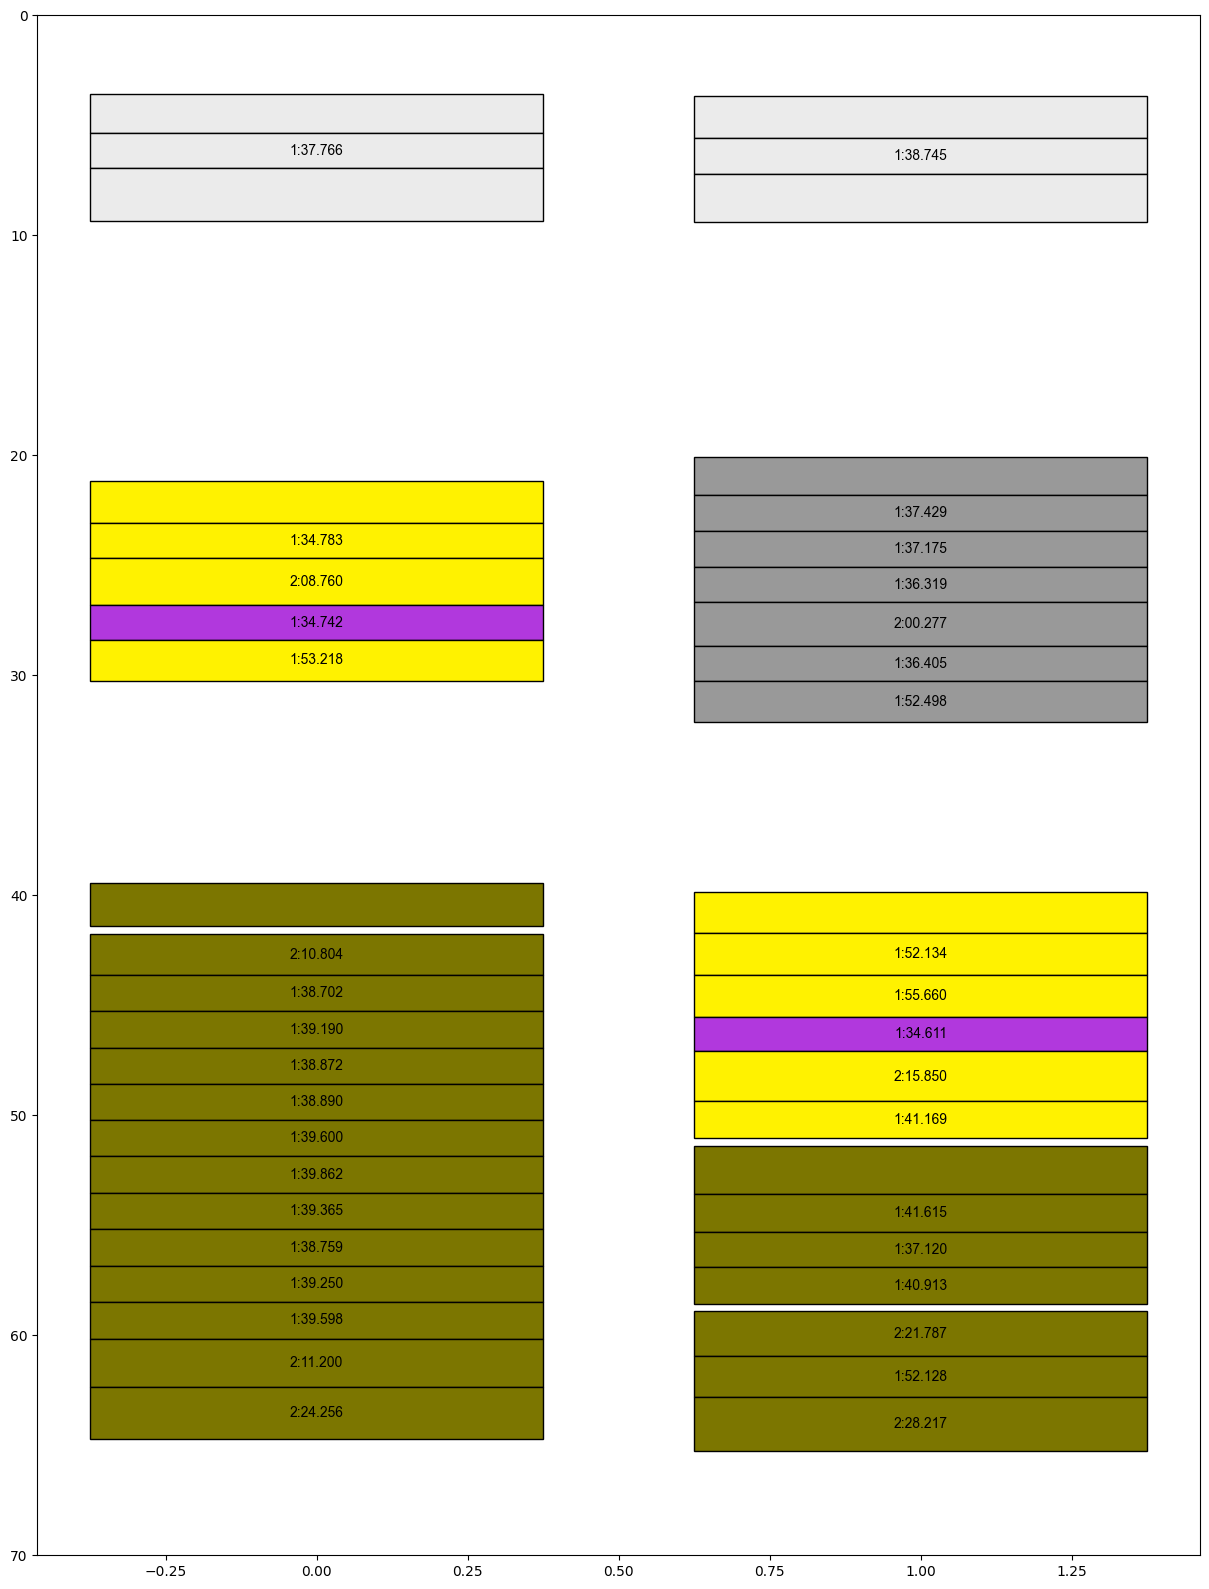

In [75]:
plt.rcParams["figure.figsize"] = [15,20]
plt.ylim((70,0))
for driverId in range(2):
    singleDriverDataFrame = lapsDataFrame[lapsDataFrame["DriverNumber"]==session.drivers[driverId]]
    oldColumns = singleDriverDataFrame.columns.to_list()
    usefulColumns = ['DriverNumber','LapTime','CorrectedPitOutTime','CorrectedTime','CorrectedPitInTime','IsPersonalBest','Compound','FreshTyre','Team']
    for x in oldColumns:
        if x not in usefulColumns:
            del singleDriverDataFrame[x]

    tyreColor = []
    rectangleStart = []
    rectangleStop = []
    lapTimes = []
    for i in range(len(singleDriverDataFrame["CorrectedPitOutTime"].to_list())):
        #tyre coloring
        if singleDriverDataFrame["IsPersonalBest"].to_list()[i]:
            tyreColor.append("PersonalBest")
        else:
            tyreString = ""
            if singleDriverDataFrame["FreshTyre"].to_list()[i]:
                tyreString = "Fresh"
            else:
                tyreString = "Used"
            tyreString = tyreString + singleDriverDataFrame["Compound"].to_list()[i]
            tyreColor.append(tyreString)
        #start of rectangle
        if pd.isnull(singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i]):
            rectangleStart.append((singleDriverDataFrame["CorrectedTime"].to_list()[i-1].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i-1].microseconds/1000000)/60)
        else:
            rectangleStart.append((singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitOutTime"].to_list()[i].microseconds/1000000)/60)
        #end of rectangle
        if pd.isnull(singleDriverDataFrame["CorrectedPitInTime"].to_list()[i]):
            rectangleStop.append((singleDriverDataFrame["CorrectedTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedTime"].to_list()[i].microseconds/1000000)/60)
        else:
            rectangleStop.append((singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].seconds+singleDriverDataFrame["CorrectedPitInTime"].to_list()[i].microseconds/1000000)/60)
        if pd.isnull(singleDriverDataFrame["LapTime"].to_list()[i]):
            lapTimes.append("")
        else:
            if len(str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60))==2:
                correctSeconds = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
            else:
                correctSeconds = "0"+str(singleDriverDataFrame["LapTime"].to_list()[i].seconds%60)
            lapTime = str(singleDriverDataFrame["LapTime"].to_list()[i].seconds//60)+":"+correctSeconds+"."+str(singleDriverDataFrame["LapTime"].to_list()[i].microseconds)[0:3]
            lapTimes.append(lapTime)
    for x in range(len(lapTimes)):
        plt.bar(driverId,rectangleStop[x]-rectangleStart[x],0.75,rectangleStart[x], data = lapTimes[x], color=compoundColors[tyreColor[x]], edgecolor = "black")
        plt.text(driverId,rectangleStop[x]-(rectangleStop[x]-rectangleStart[x])/2,lapTimes[x],verticalalignment='center',horizontalalignment='center',fontfamily='Arial')

In [46]:
singleDriverDataFrame

,DriverNumber,LapTime,IsPersonalBest,Compound,FreshTyre,Team,CorrectedPitOutTime,CorrectedTime
0,1,NaT,False,HARD,True,Red Bull Racing,0 days 00:03:33.405000,0 days 00:05:19.921000
1,1,0 days 00:01:37.766000,False,HARD,True,Red Bull Racing,NaT,0 days 00:06:57.687000
2,1,NaT,False,HARD,True,Red Bull Racing,NaT,0 days 00:21:10.153000
3,1,NaT,False,MEDIUM,True,Red Bull Racing,0 days 00:21:10.153000,0 days 00:23:04.847000
4,1,0 days 00:01:34.783000,False,MEDIUM,True,Red Bull Racing,NaT,0 days 00:24:39.630000
5,1,0 days 00:02:08.760000,False,MEDIUM,True,Red Bull Racing,NaT,0 days 00:26:48.390000
6,1,0 days 00:01:34.742000,True,MEDIUM,True,Red Bull Racing,NaT,0 days 00:28:23.132000
7,1,0 days 00:01:53.218000,False,MEDIUM,True,Red Bull Racing,NaT,0 days 00:30:16.350000
8,1,NaT,False,MEDIUM,False,Red Bull Racing,0 days 00:39:27.610000,0 days 00:41:26.512000
9,1,0 days 00:02:10.804000,False,MEDIUM,False,Red Bull Racing,0 days 00:41:46.450000,0 days 00:43:37.316000
